In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pygazeanalyser
import matplotlib
from matplotlib import pyplot as plt
from pygazeanalyser.edfreader import read_edf
from scipy import stats, signal, ndimage
import re
import os
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [6]:
# set relevant directories and paths
#workingfolder = '/Users/user/Desktop/Experiments/Nick/AttentionSaccade/' #laptop directory
workingfolder = '/home/sammirc/Experiments/Nick/AttentionSaccade' #workstation directory
eyedat        = os.path.join(workingfolder, 'eyes')
behdat        = os.path.join(workingfolder, 'behaviour/csv')
eegdat        = os.path.join(workingfolder, 'EEG') #only on workstation though, no eeg data on laptop
eyelist       = os.listdir(eyedat)
eyelist       = np.sort(eyelist)
behlist       = np.sort(os.listdir(behdat))
saccadedat    = os.path.join(workingfolder, 'saccades')
if not os.path.exists(saccadedat):
    os.mkdir(saccadedat)
sublist = [4, 5, 6, 7, 8, 9]
parts   = ['a','b']
#1KHz  sample: 1 5 6 7 8 9
#250Hz sample: 4

In [7]:
# specs for the task
resxy = (1920,1080)
scrsize = (60,34)
scrdist = 100 # cm
#pixpcm = np.mean([resxy[0]/scrsize[0],resxy[1]/scrsize[1]])
#samplerate = 1000.0 # Hz , sample every 1ms. subject 4 has 250Hz SR, all other 1kHz
samplerate = 250.0 #for subject 4
# Data files
sep = '\t' #value separator
EDFSTART = "_BEG"
EDFSTOP  = "END"
TRIALORDER = ["B(.*)_T(.*)_BEG","B(.*)_T(.*)_CUE","B(.*)_T(.*)_ARR","B(.*)_T(.*)_RESP","B(.*)_T(.*)_END"]
INVALCODE = np.NaN

In [10]:
for sub in range(len(sublist)):
    for part in range(len(parts)):
        print('working on S%02d%s'%(sublist[sub], parts[part]))
        fname   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[part]))
        datname = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[part]))
        bdata   = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False)
        edata   = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
    # columns in the behavioural data
    # subject  - subject number
    # session  - session number
    # task     - task type (1 = attention, 2 = saccade)
    # cuecol   - 
    # cueloc   - cued location (1:8)
    # validity - validity of cue (1 = valid, 0 = invalid)
    # targloc  - location of target (1:8) - can be same or different to cueloc depending on validity of trial
    # targtilt - orientation of target (1 = , 2 = )
    # delay    -
    # resp     - response made: 0 = no response, 1 = , 2 = 
    # time     - NaN on saccade trials (or trials with no response), otherwise RT in seconds
    # corr     - accuracy of trial (1 = correct, 0 = incorrect), all saccade trials coded with 0 as no response
        print('combining eyetracking and behavioural data, and adding triggers to eyetracking data')
        for trial in range(len(edata)):
            trl          = bdata.iloc[trial,:]
            edata[trial]['behaviour'] = {
                'subject'  : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'     : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'   : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'  : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'    : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'     : trl.loc['time']    , 'corr'     : trl.loc['corr']     }
            trigs = edata[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]
                }
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                }
            edata[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]     
        print('writing saccade data to file now')
        saccfname = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[part])
        saccfile     = open(saccfname, 'w')
        saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format('subject','trial','start','end',
                                                                 'duration','startx', 'starty', 
                                                                 'endx', 'endy', 'velocity'))
        for trial in range(len(edata)):
            saccades = edata[trial]['events']['Esac']
            tnum = trial + 1
            subject = edata[trial]['behaviour']['subject']
            ttime = edata[trial]['trackertime'][0]
        #saccades[saccade]: start, end, duration, startx, starty, endx, endy
            for saccade in range(len(saccades)):
                saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                     (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(subject,tnum,
                                                                         saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,saccades[saccade][2],
                                                                         saccades[saccade][3],saccades[saccade][4],saccades[saccade][5],
                                                                         saccades[saccade][6],saccadevel))
        saccfile.close()

print('done!')

working on S04a
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S04b
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S05a
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S05b
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S06a
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S06b
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S07a
combining eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S07b
combining eyetracking and behavioural data, and addin

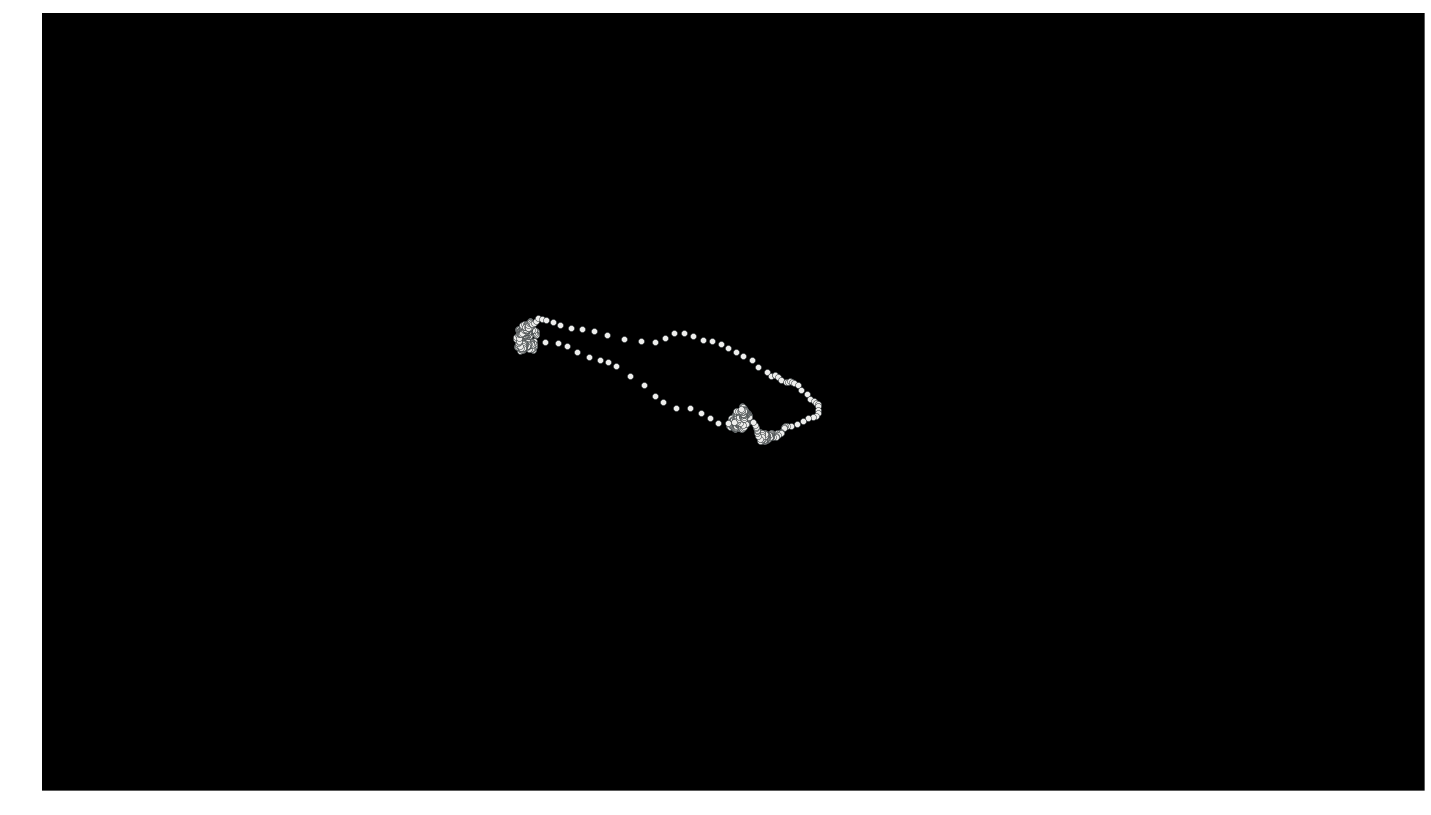

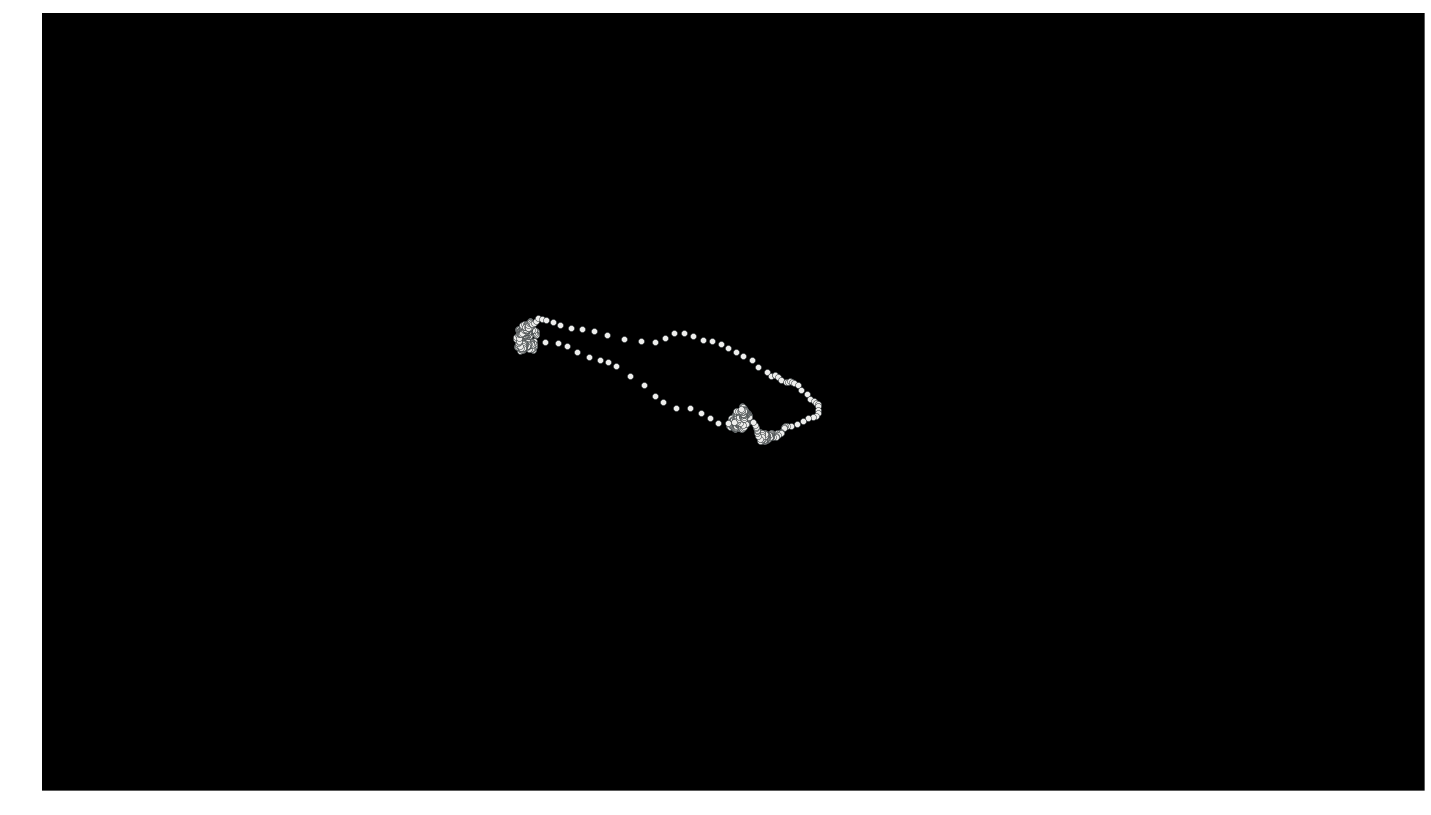

In [37]:
from pygazeanalyser import gazeplotter
trial = 95
gazeplotter.draw_raw(edata[trial]['x'], edata[trial]['y'], dispsize = resxy)
#help(gazeplotter.draw_scanpath)
#gazeplotter.draw_scanpath(fixations = edata[trial]['events']['Efix'],
                          #saccades = edata[trial]['events']['Esac'],
                          #dispsize = resxy)